# Calibration of the school model based on empirical data

In [4]:
import numpy as np
import pandas as pd
import numpy as np
from os.path import join
import json

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# custom functions to run the calibration simulations
import calibration_functions as cf

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

## Empirical observations

In [5]:
# school types over which the calibration us run
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary']

In [6]:
empirical_data_src = '../../data/calibration/empirical_observations'

# distribution of outbreak sizes by school type
outbreak_sizes = pd.read_csv(\
            join(empirical_data_src, 'empirical_outbreak_sizes.csv'))
# ratio of infections in the student and teacher groups
group_distributions = pd.read_csv(\
            join(empirical_data_src, 'empirical_group_distributions.csv'))
# ratio of index cases in the student and teacher groups
agent_index_ratios = pd.read_csv(\
            join(empirical_data_src, 'empirical_index_case_ratios.csv'))
agent_index_ratios.index = agent_index_ratios['school_type']
# ratio of symptomatic cases in the student and teacher groups
symptomatic_case_ratios = pd.read_csv(\
            join(empirical_data_src, 'empirical_symptomatic_case_ratios.csv'))

In [7]:
# note: these are the number of clusters per school type from the slightly older
# data version (November 2020). For primary and lower secondary school types,
# the counts are split evenly between schools with and without daycare. 
counts = pd.DataFrame({'type':['primary', 'primary_dc', 
                               'lower_secondary', 'lower_secondary_dc',
                               'upper_secondary', 'secondary'],
                      'count':[33.5, 33.5, 90, 90, 116, 70]})

counts.index = counts['type']
counts = counts.drop(columns=['type'])
# The cluster counts are used to weigh the respective school type in the 
# calibration process.
counts['weight'] = counts['count'] / counts['count'].sum()

## Simulation settings

In [8]:
# List of prevention measures that were in place in schools in the weeks 36-45
# of the year 2020 in Austrian schools. This list was compiled from information
# collected in interviews with teachers of different school types. NOTE: so far
# there are no recorded differences between school types.
with open('params/calibration_measures.json', 'r') as fp:
    prevention_measures = json.load(fp)
# simulation parameters, specifically the
# - base transmission risk (calibrated from household transmissions)
# - subclinical transmission modifier (literature value)
# - exposure duration, time until symtpoms and infection duration (lit. values)
# - age symptom discount (fit to empirical observations)
with open('params/calibration_simulation_parameters.json', 'r') as fp:
    simulation_params = json.load(fp)
# characteristics (# classes, # students / class, # teachers) of the "average" 
# school, depending on school type. These characteristics were determined in 
# interviews with Austrian teachers and from statistics about Austrian schools 
# (year 2017/18, page 10: https://www.bmbwf.gv.at/Themen/schule/schulsystem/gd.html)
# NOTE: "students" indicates the number of students per class
with open('params/calibration_school_characteristics.json', 'r') as fp:
    school_characteristics = json.load(fp)

## Coarse grid search with age dependence

### Create calibration parameter grid

In [124]:
## grid of parameters that need to be calibrated

N_runs = 500

# the contact weight is the modifier by which the base transmission risk (for
# household transmissions) is multiplied for contacts of type "intermediate" 
# and of type "far"
intermediate_contact_weights_coarse = np.arange(0, 1, 0.05)
far_contact_weights_coarse = np.arange(0, 1, 0.05)

# the age_transmission_discount sets the slope of the age-dependence of the 
# transmission risk. Transmission risk for adults (age 18+) is always base 
# transmission risk. For every year an agent is younger than 18 years, the
# transmission risk is reduced
age_transmission_discounts_coarse = np.arange(-0.1, 0, 0.02)

# list of all possible parameter combinations from the grid
screening_params = [(N_runs, i, round(j, 2), round(k, 2), round(l, 2))\
                    for i in school_types \
                    for j in intermediate_contact_weights_coarse \
                    for k in far_contact_weights_coarse\
                    for l in age_transmission_discounts_coarse if j > k]

print('There are {} parameter combinations to sample.'.format(len(screening_params)))

There are 5700 parameter combinations to sample.


### Run the sampling

In [11]:
def run(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters test_type, 
        index_case, e_screen_range and r_screen_range that are passed to the
        simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, intermediate_contact_weight, far_contact_weight,\
                age_transmission_discount = params

    # run the ensemble with the given parameter combination and school type
    ensemble_results = cf.run_ensemble(N_runs, school_type,
            intermediate_contact_weight, far_contact_weight, 
            age_transmission_discount, prevention_measures,
            school_characteristics, agent_index_ratios,
            simulation_params, contact_network_src, ensmbl_dst)

    # calculate the difference between the ensemble characteristics
    # (outbreak distribution, ratio of student to teacher cases)
    row = cf.evaluate_ensemble(ensemble_results, school_type,
            intermediate_contact_weight, far_contact_weight,
            age_transmission_discount, outbreak_sizes, group_distributions)
    
    return row

In [10]:
%%time
contact_network_src = '../../data/contact_networks/calibration'
ensmbl_dst = '../../data/calibration/simulation_results/ensembles'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

rows = []
for row in tqdm(pool.imap_unordered(func=run, iterable=screening_params),
                total=len(screening_params)):
        rows.append(row)

# turn off your parallel workers 
pool.close()

# format and dump the results to disk
dst = '../../data/calibration/simulation_results'
results = pd.DataFrame()
for row in rows:
    results = results.append(row, ignore_index=True)
    
results.reset_index()
index_cols = ['school_type', 'intermediate_contact_weight',
              'far_contact_weight', 'age_transmission_discount']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst,'calibration_results_coarse_sampling_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 1140/1140 [42:22:22<00:00, 133.81s/it]    


CPU times: user 13.7 s, sys: 2.82 s, total: 16.5 s
Wall time: 1d 18h 22min 25s


,school_type,intermediate_contact_weight,far_contact_weight,age_transmission_discount,chi2_distance_distro,chi2_distance_size,chi2_distance_total,sum_of_squares_distro,sum_of_squares_size,sum_of_squares_total
0,primary,0.15,0.10,0.0,0.060263,0.210431,0.270695,0.088963,0.267885,0.356848
1,primary,0.25,0.15,0.0,0.067555,0.072562,0.140117,0.099727,0.091221,0.190948
2,primary,0.20,0.10,0.0,0.072661,0.152732,0.225393,0.107265,0.194364,0.301629


### Analyze the coarse sampling

In [51]:
# gather the data 
# NOTE: due to computational cost, the calibraiton simulations for the different
# school types were run in different batches and need to be combined before
# analysis
dst = '../../data/calibration/simulation_results'
N = 500
results_coarse = pd.DataFrame()
for st in school_types:
    tmp = pd.read_csv(join(dst, 'calibration_results_coarse_sampling_{}_{}.csv'\
                        .format(N, st)))
    results_coarse = pd.concat([results_coarse, tmp])
results_coarse['intermediate_contact_weight'] = results_coarse['intermediate_contact_weight'].round(2)
results_coarse['far_contact_weight'] = results_coarse['far_contact_weight'].round(2)
results_coarse['age_transmission_discount'] = results_coarse['age_transmission_discount'].round(2)
results_coarse.head(3)

,school_type,intermediate_contact_weight,far_contact_weight,age_transmission_discount,chi2_distance_size,sum_of_squares_size,chi2_distance_distro,sum_of_squares_distro,chi2_distance_total,sum_of_squares_total
0,primary,0.10,0.05,-0.02,0.265863,0.339667,0.095166,0.140487,0.361028,0.480154
1,primary,0.20,0.10,-0.06,0.261812,0.333982,0.027287,0.040281,0.289098,0.374263
2,primary,0.15,0.00,-0.08,0.291058,0.372044,0.010149,0.014982,0.301207,0.387026


In [52]:
results_coarse['chi2_distance_total_weighted'] = results_coarse['chi2_distance_total']
for i, row in results_coarse.iterrows():
    st = row['school_type']
    weight = counts.loc[st, 'weight']
    error = row['chi2_distance_total']
    results_coarse.loc[i, 'chi2_distance_total_weighted'] = error * weight

In [53]:
# since we calibrate the intermediate_contact_weight, far_contact_weight and 
# age_transmission_discount over all school types together, we have to find
# the parameter combination that minimizes the sum of errors over all school
# types. 
agg_results_coarse = results_coarse.groupby(['intermediate_contact_weight',
                'far_contact_weight', 'age_transmission_discount']).sum()

opt_coarse = agg_results_coarse.loc[\
        agg_results_coarse['chi2_distance_total_weighted'].idxmin()].name
opt_intermediate_contact_weight_coarse = opt_coarse[0]
opt_far_contact_weight_coarse = opt_coarse[1]
opt_age_transmission_discount_coarse = opt_coarse[2]

print('optimal random sampling parameter combination:')
print('\t intermediate contact weight: {:1.3f}'\
      .format(opt_intermediate_contact_weight_coarse))
print('\t far contact weight: {:1.3f}'\
      .format(opt_far_contact_weight_coarse))
print('\t age transmission discount: {:1.3f}'\
      .format(opt_age_transmission_discount_coarse))

optimal random sampling parameter combination:
	 intermediate contact weight: 0.900
	 far contact weight: 0.150
	 age transmission discount: -0.080


In [54]:
images = {round(atd, 2):np.zeros((len(intermediate_contact_weights_coarse),
            len(far_contact_weights_coarse))) \
            for atd in age_transmission_discounts_coarse}

for atd in age_transmission_discounts_coarse:
    atd = round(atd, 2)
    img_coarse = images[atd]
    for i, intermediate in enumerate(intermediate_contact_weights_coarse):
        for j, far in enumerate(far_contact_weights_coarse):
            intermediate = round(intermediate, 2)
            far = round(far, 2)
            try:
                img_coarse[i, j] = agg_results_coarse\
                    .loc[intermediate, far, atd]['chi2_distance_total_weighted']
            except KeyError:
                img_coarse[i, j] = np.nan

In [61]:
def my_ceil(a, precision=0):
    return np.round(a + 0.5 * 10**(-precision), precision)

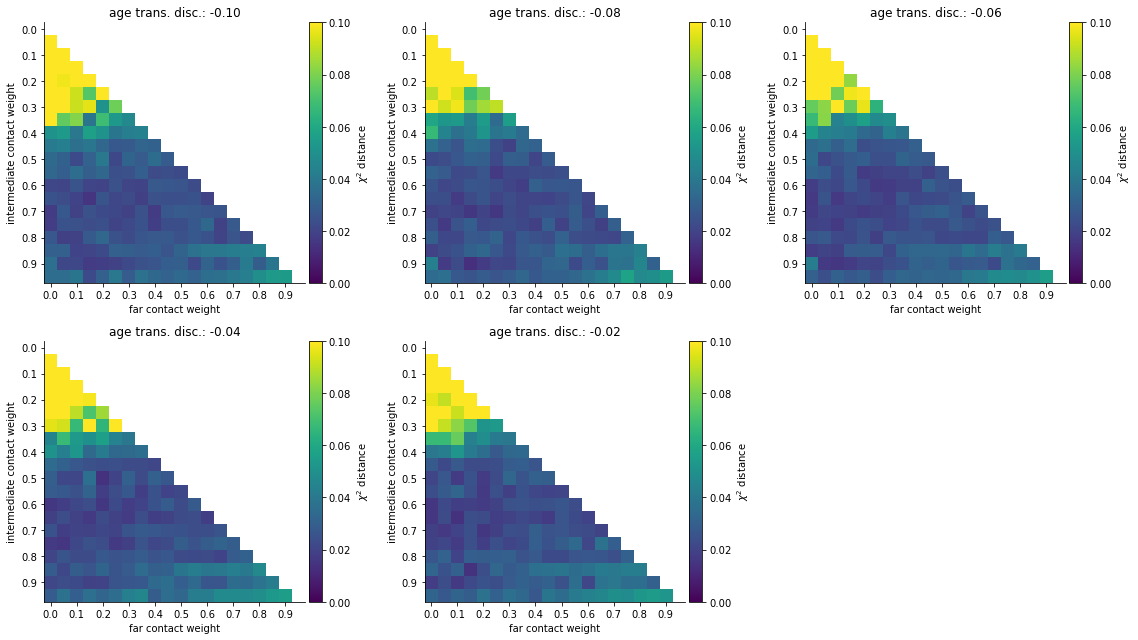

In [79]:
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
vmin = 0
vmax = my_ceil(agg_results_coarse['chi2_distance_total_weighted'].max(),
               precision=1)
vmax = 0.1

for ax, atd in zip(axes.flatten(), age_transmission_discounts_coarse):
    atd = round(atd, 2)
    im = ax.imshow(images[atd], vmin=vmin, vmax=vmax)
    ax.set_yticks(range(len(intermediate_contact_weights_coarse))[::2])
    ax.set_yticklabels(['{:1.1f}'.format(icw) for \
                        icw in intermediate_contact_weights_coarse[::2]])
    ax.set_xticks(range(len(far_contact_weights_coarse))[::2])
    ax.set_xticklabels(['{:1.1f}'.format(fcw) for \
                        fcw in far_contact_weights_coarse[::2]])

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label('$\chi^2$ distance')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_ylabel('intermediate contact weight')
    ax.set_xlabel('far contact weight')
    ax.set_title('age trans. disc.: {:1.2f}'.format(atd))
    
axes[1,2].set_axis_off()
fig.tight_layout()

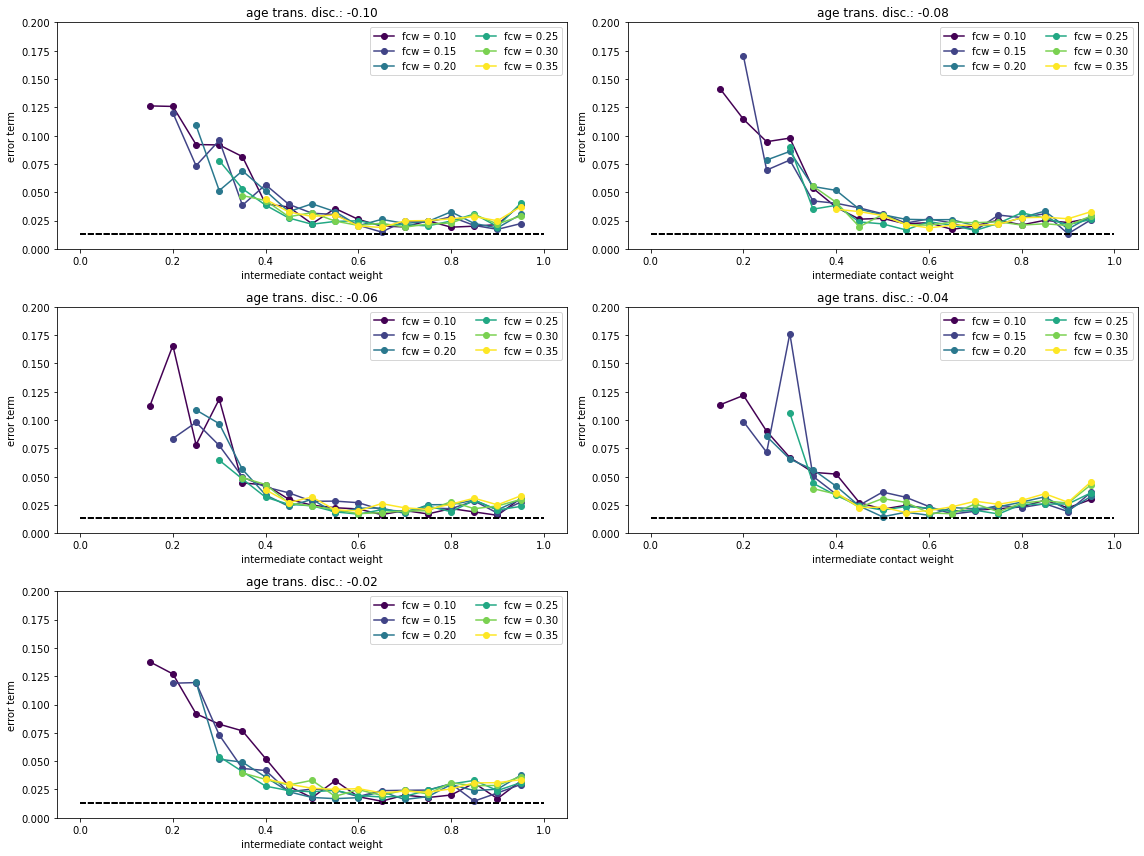

In [91]:
agg_results_selection_coarse = agg_results_coarse.copy().reset_index()

fig, axes = plt.subplots(3, 2, figsize=(16,12))
cmap = plt.get_cmap('viridis')
global_min = agg_results_coarse['chi2_distance_total_weighted'].min()

for ax, atd in zip(axes.flatten(), age_transmission_discounts_coarse):
    atd = round(atd, 2)

    for i, far_level in enumerate(far_contact_weights_coarse[2:-12]):
        far_level = round(far_level, 2)
        agg_results_level = agg_results_selection_coarse[\
            (agg_results_selection_coarse['far_contact_weight'] == far_level) &\
            (agg_results_selection_coarse['age_transmission_discount'] == atd)]\
            .reset_index(drop=True)

        #popt, pcov = curve_fit(func, 
        #        agg_results_level['intermediate_contact_weight'],
        #        agg_results_level['chi2_distance_total_weighted'])

        ax.plot(agg_results_level['intermediate_contact_weight'],
                agg_results_level['chi2_distance_total_weighted'],
                'o-', color=cmap(i/(len(far_contact_weights_coarse[2:-12]) - 1)),
                label='fcw = {:1.2f}'.format(far_level))
        
        ax.plot([0, 1], [global_min, global_min], '--', color='k')

        #x = np.arange(0, 1.01, 0.01)
        #ax.plot(x, func(x, *popt),
        #        color=cmap(i/(len(far_contact_weights_coarse[0:-8]) - 2)))

    ax.set_ylabel('error term')
    ax.set_xlabel('intermediate contact weight')
    ax.legend(ncol=2, loc=0)
    ax.set_ylim(0, 0.2)
    ax.set_title('age trans. disc.: {:1.2f}'.format(atd))
    
axes[2,1].set_axis_off()
fig.tight_layout()

## Fine grid search with age dependence

### Create calibration parameter grid

In [69]:
print('optimal random sampling parameter combination:')
print('\t intermediate contact weight: {:1.3f}'\
      .format(opt_intermediate_contact_weight_coarse))
print('\t far contact weight: {:1.3f}'\
      .format(opt_far_contact_weight_coarse))

optimal random sampling parameter combination:
	 intermediate contact weight: 0.300
	 far contact weight: 0.250


In [70]:
## grid of parameters that need to be calibrated
N_runs = 500

# school types over which the calibration us run
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary']

# the contact weight is the modifier by which the base transmission risk (for
# household transmissions) is multiplied for contacts of type "intermediate" 
# and of type "far". Parameter values are chosen around the optimum from the
# previous random sampling search
intermediate_contact_weights_fine = np.hstack([
    np.arange(opt_intermediate_contact_weight_coarse - 0.05, 
              opt_intermediate_contact_weight_coarse, 0.01),
    np.arange(opt_intermediate_contact_weight_coarse, 
              opt_intermediate_contact_weight_coarse + 0.06, 0.01)
    ])

far_contact_weights_fine = np.hstack([
    np.arange(opt_far_contact_weight_coarse - 0.05, 
              opt_far_contact_weight_coarse, 0.01),
    np.arange(opt_far_contact_weight_coarse, 
              opt_far_contact_weight_coarse + 0.06, 0.01)
    ])

# the age_transmission_discount sets the slope of the age-dependence of the 
# transmission risk. Transmission risk for adults (age 18+) is always base 
# transmission risk. For every year an agent is younger than 18 years, the
# transmission risk is reduced. Parameter values are chosen around the optimum 
# from the previous random sampling search
age_transmission_discounts_fine = [-0.015,-0.0175,-0.0225,-0.025,-0.0275]

print('intermediate: ', intermediate_contact_weights_fine)
print('far: ', far_contact_weights_fine)

# list of all possible parameter combinations from the grid
# Note: the age transmission discount is set to 0 for all parameter
# combinations here
screening_params = [(N_runs, i, j, k, l) for i in school_types \
                    for j in intermediate_contact_weights_fine \
                    for k in far_contact_weights_fine \
                    for l in age_transmission_discounts_fine if j > k]

print('There are {} parameter combinations to sample.'.format(len(screening_params)))

intermediate:  [0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35]
far:  [0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3 ]
There are 600 parameter combinations to sample.


### Run the sampling

In [109]:
%%time
contact_network_src = '../../data/contact_networks/calibration'
ensmbl_dst = '../../data/calibration/simulation_results/ensembles'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

rows = []
for row in tqdm(pool.imap_unordered(func=run, iterable=screening_params),
                total=len(screening_params)):
        rows.append(row)

# turn off your parallel workers 
pool.close()

# format and dump the results to disk
dst = '../../data/calibration/simulation_results'
results = pd.DataFrame()
for row in rows:
    results = results.append(row, ignore_index=True)
    
results.reset_index()
index_cols = ['school_type', 'intermediate_contact_weight',
              'far_contact_weight', 'age_transmission_discount']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst,'calibration_results_fine_sampling_noage_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 600/600 [19:54:15<00:00, 119.43s/it]    


CPU times: user 7.04 s, sys: 1.41 s, total: 8.45 s
Wall time: 19h 54min 17s


,school_type,intermediate_contact_weight,far_contact_weight,age_transmission_discount,chi2_distance_distro,chi2_distance_size,chi2_distance_total,sum_of_squares_distro,sum_of_squares_size,sum_of_squares_total
0,primary,0.26,0.25,0.0,0.089444,0.054324,0.143768,0.132040,0.068568,0.200608
1,primary,0.25,0.24,0.0,0.059658,0.066652,0.126310,0.088069,0.083824,0.171893
2,primary,0.25,0.21,0.0,0.078605,0.120814,0.199419,0.116039,0.154010,0.270049


### Analyze the fine grid search

In [138]:
def check_results(row):
    exclude = [[0.25, 0.2], [0.3, 0.2], [0.35, 0.2],
               [0.3, 0.25], [0.35, 0.25], [0.35, 0.3]]
    weights = [row['intermediate_contact_weight'], row['far_contact_weight']]
    return weights not in exclude

In [16]:
# load the collected ensemble statistics
dst = '../../data/calibration/simulation_results'
results_fine = pd.read_csv(\
    join(dst, 'calibration_results_fine_sampling_noage_{}.csv'.format(N)))
results_fine['intermediate_contact_weight'] = results_fine['intermediate_contact_weight'].round(2)
results_fine['far_contact_weight'] = results_fine['far_contact_weight'].round(2)
results_fine.head(3)

,school_type,intermediate_contact_weight,far_contact_weight,age_transmission_discount,chi2_distance_distro,chi2_distance_size,chi2_distance_total,sum_of_squares_distro,sum_of_squares_size,sum_of_squares_total
0,primary,0.26,0.25,0.0,0.089444,0.054324,0.143768,0.132040,0.068568,0.200608
1,primary,0.25,0.24,0.0,0.059658,0.066652,0.126310,0.088069,0.083824,0.171893
2,primary,0.25,0.21,0.0,0.078605,0.120814,0.199419,0.116039,0.154010,0.270049


In [17]:
results_fine['chi2_distance_total_weighted'] = results_fine['chi2_distance_total']
for i, row in results_fine.iterrows():
    st = row['school_type']
    weight = counts.loc[st, 'weight']
    error = row['chi2_distance_total']
    results_fine.loc[i, 'chi2_distance_total_weighted'] = error * weight

In [18]:
agg_results_fine = results_fine.groupby(['intermediate_contact_weight',
                 'far_contact_weight']).sum()
opt_fine = agg_results_fine.loc[\
        agg_results_fine['chi2_distance_total_weighted'].idxmin()].name
opt_intermediate_contact_weight_fine = opt_fine[0]
opt_far_contact_weight_fine = opt_fine[1]

print('optimal grid search parameter combination:')
print('\t intermediate contact weight: {:1.3f}'\
      .format(opt_intermediate_contact_weight_fine))
print('\t far contact weight: {:1.3f}'\
      .format(opt_far_contact_weight_fine))

optimal grid search parameter combination:
	 intermediate contact weight: 0.300
	 far contact weight: 0.290


In [19]:
img_fine = np.zeros((len(intermediate_contact_weights_fine),
                len(far_contact_weights_fine)))
for i, intermediate in enumerate(intermediate_contact_weights_fine):
    for j, far in enumerate(far_contact_weights_fine):
        intermediate = round(intermediate, 2)
        far = round(far, 2)
        try:
            img_fine[i, j] = agg_results_fine\
                .loc[intermediate, far]['chi2_distance_total_weighted']
        except KeyError:
            img_fine[i, j] = np.nan

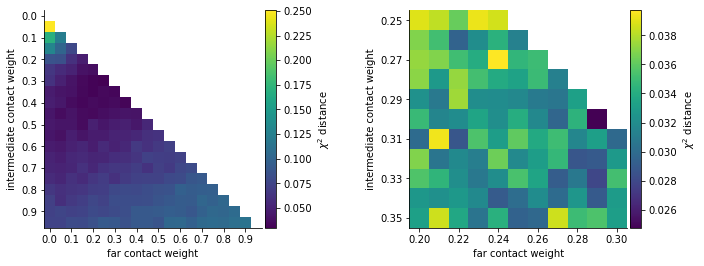

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
im1 = ax.imshow(img_coarse)
ax.set_yticks(range(len(intermediate_contact_weights_coarse))[::2])
ax.set_yticklabels(['{:1.1f}'.format(icw) for \
                    icw in intermediate_contact_weights_coarse[::2]])
ax.set_xticks(range(len(far_contact_weights_coarse))[::2])
ax.set_xticklabels(['{:1.1f}'.format(fcw) for \
                    fcw in far_contact_weights_coarse[::2]])

ax = axes[1]
im2 = ax.imshow(img_fine)
ax.set_yticks(range(len(intermediate_contact_weights_fine))[::2])
ax.set_yticklabels(['{:1.2f}'.format(icw) for \
                    icw in intermediate_contact_weights_fine[::2]])
ax.set_xticks(range(len(far_contact_weights_fine))[::2])
ax.set_xticklabels(['{:1.2f}'.format(fcw) for \
                    fcw in far_contact_weights_fine[::2]])

for ax, im in zip(axes, [im1, im2]):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label('$\chi^2$ distance')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_ylabel('intermediate contact weight')
    ax.set_xlabel('far contact weight');

In [104]:
from scipy.optimize import curve_fit
def func(x, a, c):
    return a * x ** 2 + c

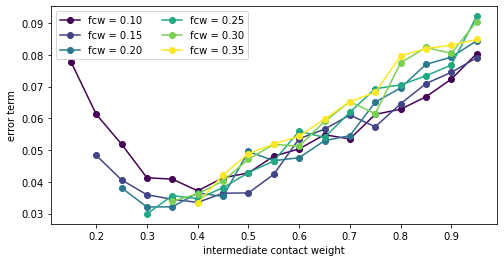

In [111]:
agg_results_selection_coarse = agg_results_coarse.copy().reset_index()

fig, ax = plt.subplots(figsize=(8,4))
cmap = plt.get_cmap('viridis')

for i, far_level in enumerate(far_contact_weights_coarse[2:-12]):
    far_level = round(far_level, 2)
    agg_results_level = agg_results_selection_coarse[\
        agg_results_selection_coarse['far_contact_weight'] == far_level]\
        .reset_index(drop=True)

    popt, pcov = curve_fit(func, 
            agg_results_level['intermediate_contact_weight'],
            agg_results_level['chi2_distance_total_weighted'])
    
    ax.plot(agg_results_level['intermediate_contact_weight'],
            agg_results_level['chi2_distance_total_weighted'],
            'o-', color=cmap(i/(len(far_contact_weights_coarse[2:-12]) - 1)),
            label='fcw = {:1.2f}'.format(far_level))
    
    #x = np.arange(0, 1.01, 0.01)
    #ax.plot(x, func(x, *popt),
    #        color=cmap(i/(len(far_contact_weights_coarse[0:-8]) - 2)))
    
ax.set_ylabel('error term')
ax.set_xlabel('intermediate contact weight')
ax.legend(ncol=2, loc=0);

In [114]:
agg_results_selection_coarse[\
        (agg_results_selection_coarse['intermediate_contact_weight'] == 0.3) &\
        (agg_results_selection_coarse['far_contact_weight'] == 0.25)]['chi2_distance_total_weighted']

20    0.02988
Name: chi2_distance_total_weighted, dtype: float64

In [115]:
agg_results_selection_fine[\
        (agg_results_selection_fine['intermediate_contact_weight'] == 0.3) &\
        (agg_results_selection_fine['far_contact_weight'] == 0.25)]['chi2_distance_total_weighted']

40    0.034088
Name: chi2_distance_total_weighted, dtype: float64

In [117]:
agg_results_selection_coarse[\
        (agg_results_selection_coarse['intermediate_contact_weight'] == 0.35) &\
        (agg_results_selection_coarse['far_contact_weight'] == 0.3)]['chi2_distance_total_weighted']

27    0.033917
Name: chi2_distance_total_weighted, dtype: float64

In [118]:
agg_results_selection_fine[\
        (agg_results_selection_fine['intermediate_contact_weight'] == 0.35) &\
        (agg_results_selection_fine['far_contact_weight'] == 0.3)]['chi2_distance_total_weighted']

99    0.033171
Name: chi2_distance_total_weighted, dtype: float64

In [119]:
agg_results_selection_coarse[\
        (agg_results_selection_coarse['intermediate_contact_weight'] == 0.25) &\
        (agg_results_selection_coarse['far_contact_weight'] == 0.2)]['chi2_distance_total_weighted']

14    0.038082
Name: chi2_distance_total_weighted, dtype: float64

In [120]:
agg_results_selection_fine[\
        (agg_results_selection_fine['intermediate_contact_weight'] == 0.25) &\
        (agg_results_selection_fine['far_contact_weight'] == 0.2)]['chi2_distance_total_weighted']

0    0.038967
Name: chi2_distance_total_weighted, dtype: float64

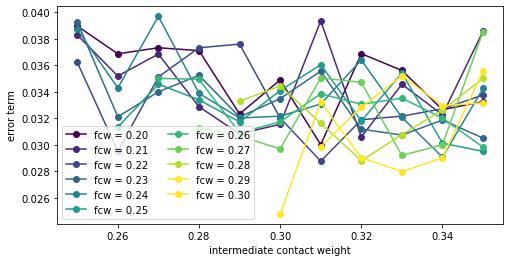

In [112]:
agg_results_selection_fine = agg_results_fine.copy().reset_index()

fig, ax = plt.subplots(figsize=(8,4))
cmap = plt.get_cmap('viridis')

for i, far_level in enumerate(far_contact_weights_fine):
    far_level = round(far_level, 2)
    agg_results_level = agg_results_selection_fine[\
        agg_results_selection_fine['far_contact_weight'] == far_level]\
        .reset_index(drop=True)

    popt, pcov = curve_fit(func, 
            agg_results_level['intermediate_contact_weight'],
            agg_results_level['chi2_distance_total_weighted'])
    
    ax.plot(agg_results_level['intermediate_contact_weight'],
            agg_results_level['chi2_distance_total_weighted'],
            'o-', color=cmap(i/(len(far_contact_weights_fine) - 2)),
            label='fcw = {:1.2f}'.format(far_level))
    
    #x = np.arange(0, 1.01, 0.01)
    #ax.plot(x, func(x, *popt),
    #        color=cmap(i/(len(far_contact_weights_coarse[0:-8]) - 2)))
    
ax.set_ylabel('error term')
ax.set_xlabel('intermediate contact weight')
ax.legend(ncol=2, loc=0);